In [4]:
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt

from utils import get_sorted_files, show_rgbd


In [5]:
def abs_rel_error(img1, img2):
  """
  Calculates the absolute relative error between two images.

  Args:
    img1: The first image as a NumPy array.
    img2: The second image as a NumPy array.

  Returns:
    The absolute relative error between the two images.
  """

  assert img1.shape == img2.shape, "Images must have the same shape"

  diff = np.abs(img1 - img2)
  rel_diff = diff / (img2 + 1e-8)  # Add a small value to avoid division by zero
  abs_rel = np.mean(rel_diff)
  return abs_rel

## least squares alignment

In [56]:


diode_path = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/"
diode_indoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/"
diode_outdoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/outdoor/"
diode_indoor_preds = "/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/indoors/"

filenames_img = get_sorted_files(diode_indoor, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_indoor_preds, ".npy")


In [57]:
index = 1
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = cv2.imread(filenames_img[index])
mask = np.load(filenames_mask[index])

---- Depth Report ----

Unique values: [ 42.524994  42.52932   42.535915 ... 469.9117   469.975    470.06952 ]
how many uniques: 770855
Max: 470.06951904296875
Min: 42.524993896484375
shape: (768, 1024)
Has nan: False
Dtype: float32


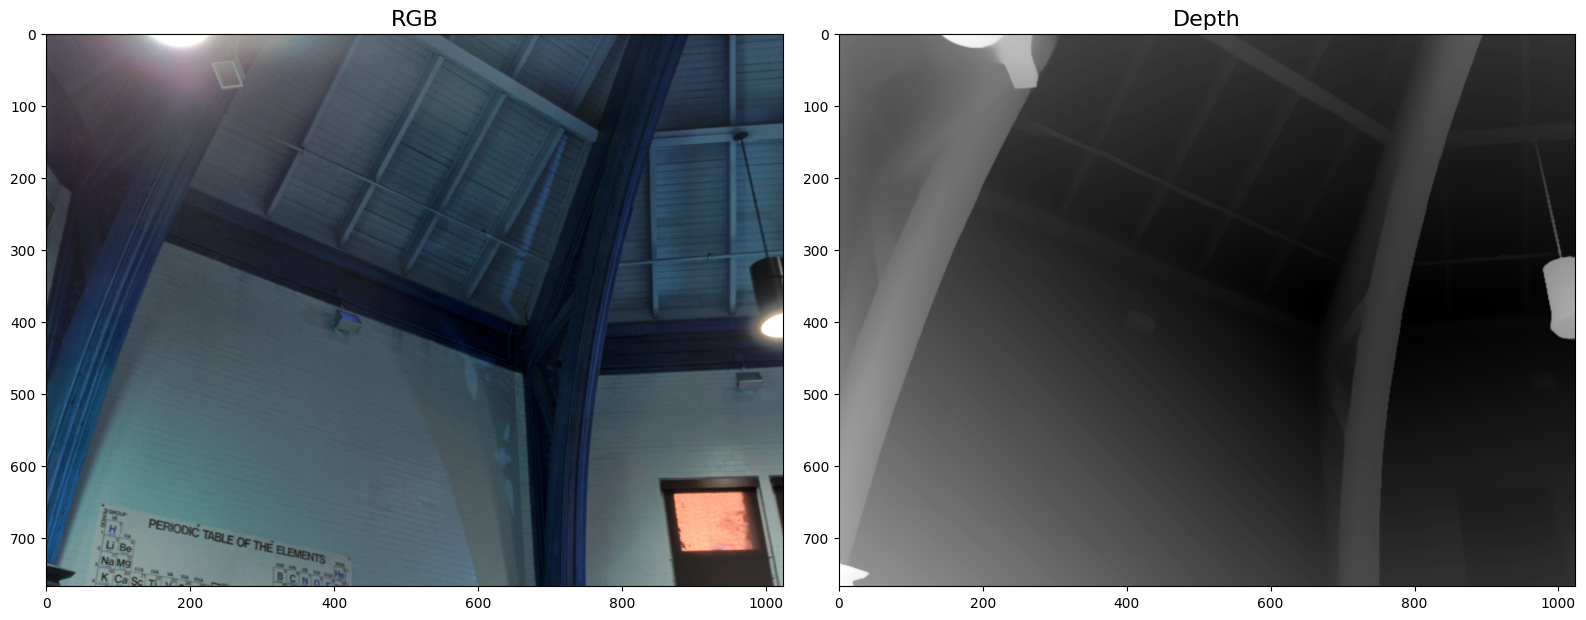

---- Depth Report ----

Unique values: [ 0.         2.4946527  2.4970303 ... 30.876266  38.751923  52.512222 ]
how many uniques: 717543
Max: 52.51222229003906
Min: 0.0
shape: (768, 1024, 1)
Has nan: False
Dtype: float32


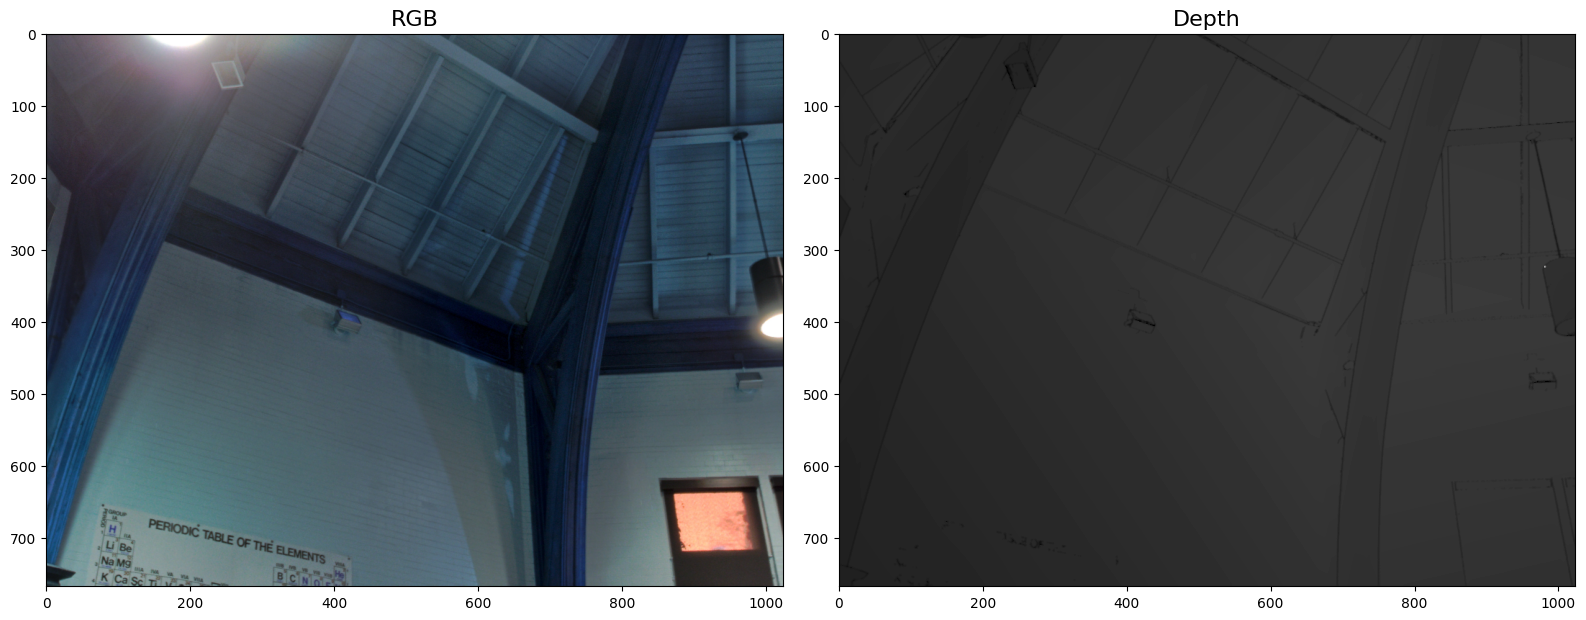

In [8]:
show_rgbd(pred_diode, rgb)
show_rgbd(groundtruth, rgb)

In [9]:
def cap_values(image, lower_percentile=2, upper_percentile=98):
    # Calculate the lower and upper percentile values
    lower_value = np.percentile(image, lower_percentile)
    upper_value = np.percentile(image, upper_percentile)

    # Cap the values
    capped_image = np.clip(image, lower_value, upper_value)

    return capped_image

In [10]:
capped_image = cap_values(groundtruth)


---- Depth Report ----

Unique values: [ 7.0740466  7.074048   7.074079  ... 11.805712  11.805742  11.805751 ]
how many uniques: 686845
Max: 11.805750846862793
Min: 7.074046611785889
shape: (768, 1024, 1)
Has nan: False
Dtype: float32


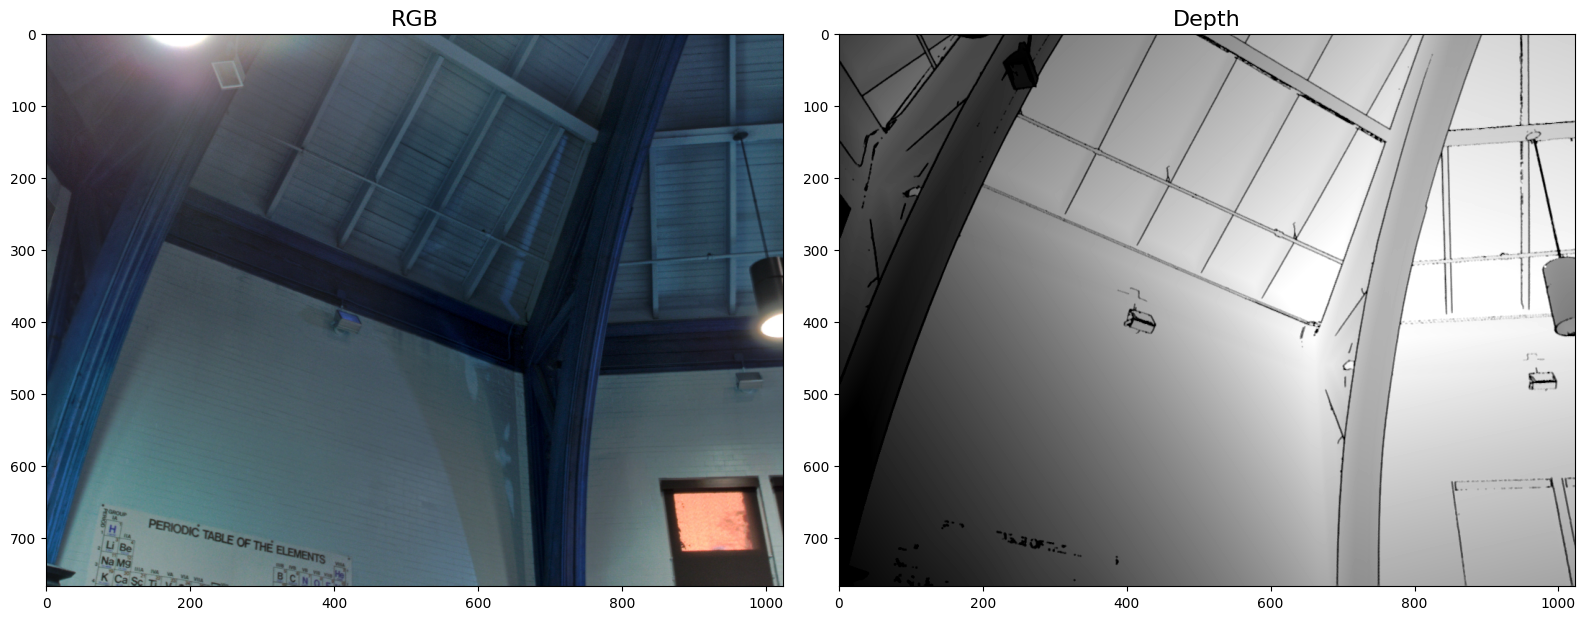

In [11]:
show_rgbd(capped_image, rgb)

In [12]:
hist = cv2.calcHist([groundtruth], [0], None, [100], [groundtruth.min(), groundtruth.max()])


In [13]:
groundtruth.max()

np.float32(52.512222)

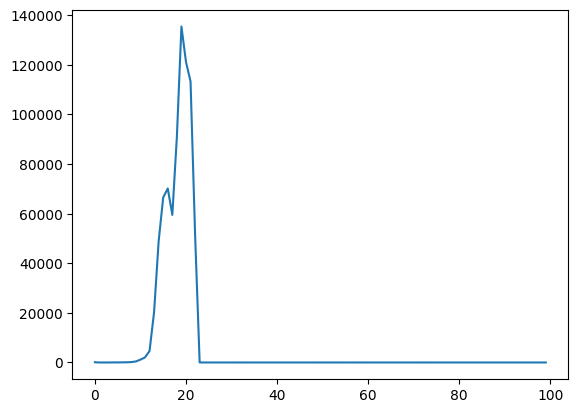

In [14]:
plt.plot(hist)

In [64]:
def compute_scale_and_shift( prediction, target, mask):
    prediction = np.expand_dims(prediction, 2)
    mask = np.expand_dims(mask, 2)
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = np.sum(mask * prediction * prediction, (1, 2))
    a_01 = np.sum(mask * prediction, (1, 2))
    a_11 = np.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = np.sum(mask * prediction * target, (1, 2))
    b_1 = np.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = np.zeros_like(b_0)
    x_1 = np.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    # A needs to be a positive definite matrix.
    valid = det > 0

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1

In [65]:
index = 1
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = cv2.imread(filenames_img[index])
mask = np.load(filenames_mask[index])

In [63]:
groundtruth.shape

(768, 1024, 1)

In [74]:
index = 1
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = cv2.imread(filenames_img[index])
mask = np.load(filenames_mask[index])
capped_image = cap_values(groundtruth)
scale, shift = compute_scale_and_shift(pred_diode, capped_image, mask)

In [59]:
mask.shape

(768, 1024)

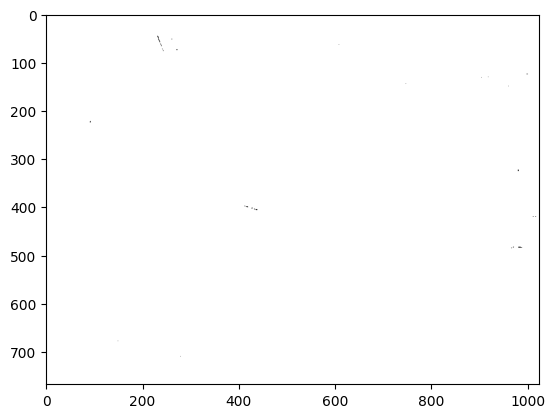

In [19]:
plt.imshow(mask, cmap="gray")

In [75]:
scale.shape

(768,)

In [72]:
shift.shape

(768,)

In [73]:
prediction_aligned = scale * pred_diode + shift


ValueError: operands could not be broadcast together with shapes (768,) (768,1024) 